In [13]:
import torch
import random
import time
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import matplotlib.pyplot as plt

from functions import enviar_chute_site


In [14]:
def get_embedding(word):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    with torch.no_grad():
        inputs = tokenizer(word)
        outputs = model(**inputs)
        # Usa o embedding do [CLS] token
        embedding = outputs.last_hidden_state[0][0].numpy()
    return embedding

In [2]:
# Inicializa navegador
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://contexto.me/en/")


In [ ]:
# memory = {}

# # Palavras genéricas para abrir sentidos semânticos
# temas_exploratorios = [
#     "object", "place", "person", "animal", "emotion",
#     "food", "vehicle", "technology", "family", "music",
#     "clothing", "tool", "plant", "profession", "color"
# ]
# temas_usados = set()

In [ ]:


# def loop_automatico():
#     reenviar_chutes_para_interface()

#     while True:
#         proxima = sugerir_proximo()
#         chute, score = enviar_chute_site(proxima)
        
#         if score is not None:
#             adicionar_chute(chute, score)
#         else:
#             print("⏭️ Ignorando chute inválido ou repetido.")

#         if score == 0:
#             print("🎉 Palavra secreta encontrada:", chute)
#             break

In [3]:
palavras_a_testar = ["place", "try", "fix", "link"]

In [15]:
for p in palavras_a_testar:
    print(get_embedding(p))
    enviar_chute_site(driver, p)


AttributeError: 'list' object has no attribute 'size'

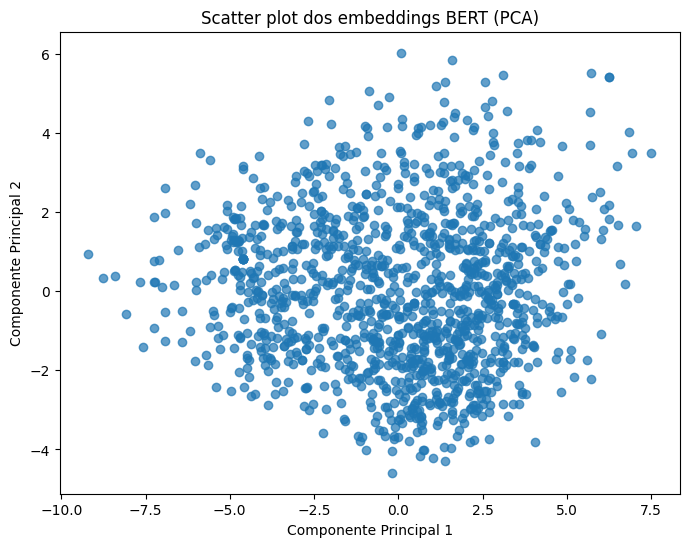

In [6]:
# Carregar os embeddings salvos em bert_embeddings.npy
embeddings = np.load('bert_embeddings.npy')

# Reduzir a dimensionalidade para 2D usando PCA para visualização
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plotar o scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.title('Scatter plot dos embeddings BERT (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()